In [1]:
import numpy as np
import os, sys
from glob import glob
from tqdm import tqdm
from time import time
import matplotlib
import matplotlib.pyplot as plt
font = {'family' : 'serif',
        'serif'  : ['Palatino'],
        'weight' : 'normal',
        'size'   : 18}
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)
import pandas as pd
import pickle as pkl
from hepstats.modeling import bayesian_blocks


def optimal_n_bins(y,max_bins=100):
    from scipy.stats import iqr
    n_bins = int((max(y) - min(y))/(2*iqr(y)*len(y)**(-1/3)))
    return min(n_bins,max_bins)


def bayesian_blocks_mod(y):
    if len(np.unique(y))==1:
        return None
    tol = np.std(y)/100
    blocks = bayesian_blocks(y)
    diffs = np.diff(blocks)
    mask = np.ones(len(blocks),dtype=bool)
    for i,d in enumerate(diffs):
        if d<tol:
            print(f'Deleting one bin: width = {d}')
            mask[i] = False
    return blocks[mask,...]

def print_stats(y):
    print(f'{np.mean(y):5.5} +/- {np.std(y):5.5}')
    
def make_hist(data,title_string,label):
    y = data.flatten()
    n_bins = 40
    plt.figure(figsize=(10,7))
    plt.hist(y,bins=n_bins,density=True)
    y_mean = np.mean(y)
    y_std = np.std(y)
    plt.title(f"{title_string}\n{y_mean:5.5} +/- {y_std:5.5}")
    plt.xlabel(label)
    plt.ylabel('Density (no units)')
    plt.xticks(rotation=45)
    plt.show()


# spin/orbit UQ

## spin part, before cuts

(3, 499200)


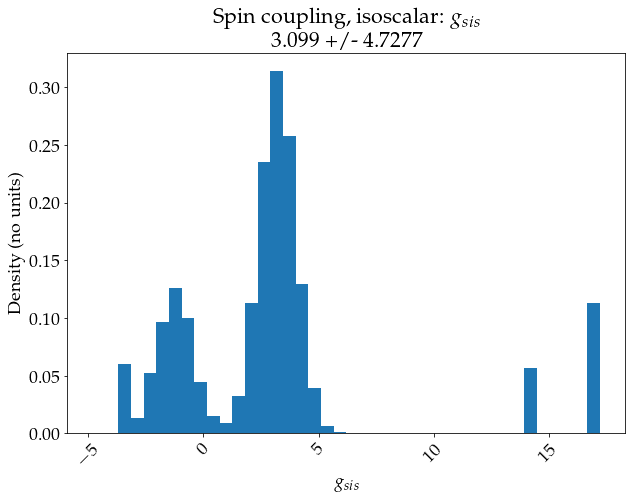

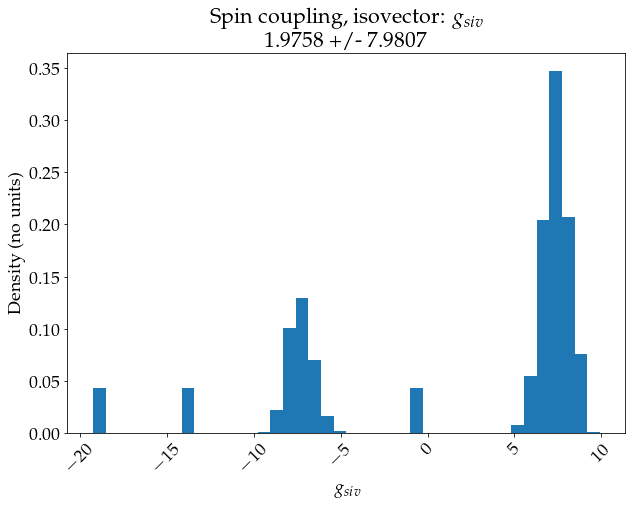

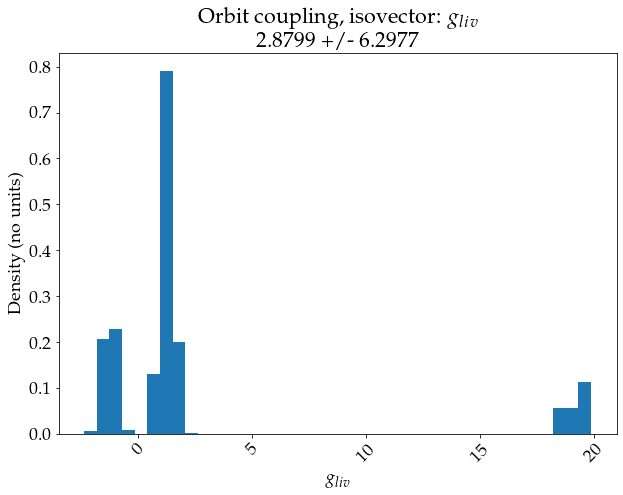

In [7]:
with open('traces_v5.0.pkl','rb') as fh:
    chain = pkl.load(fh)

# chain = [g_sis, g_siv, g_liv]
    
warmup = 400
chain = chain[:,warmup:,:]
chain = np.reshape(chain.T,(3,-1))
print(chain.shape)

g_sis_trace = chain[0].flatten()
g_siv_trace = chain[1].flatten()
g_liv_trace = chain[2].flatten()

make_hist(g_sis_trace,r'Spin coupling, isoscalar: $g_{sis}$',r'$g_{sis}$')
make_hist(g_siv_trace,r'Spin coupling, isovector: $g_{siv}$',r'$g_{siv}$')
make_hist(g_liv_trace,r'Orbit coupling, isovector: $g_{liv}$',r'$g_{liv}$')

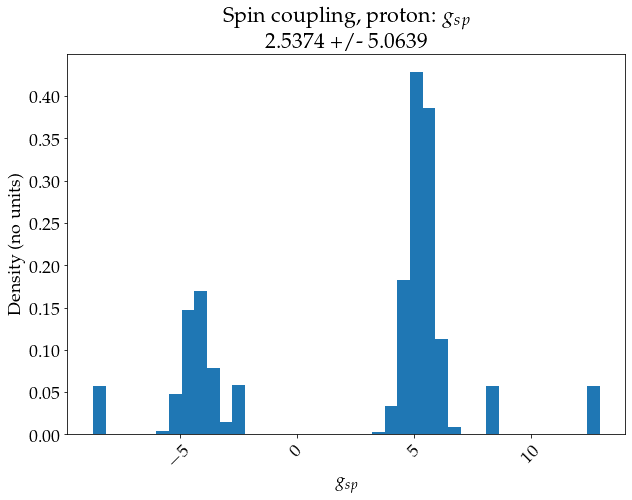

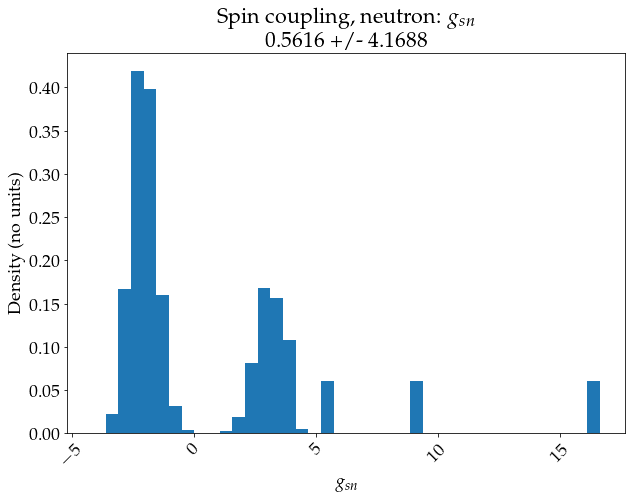

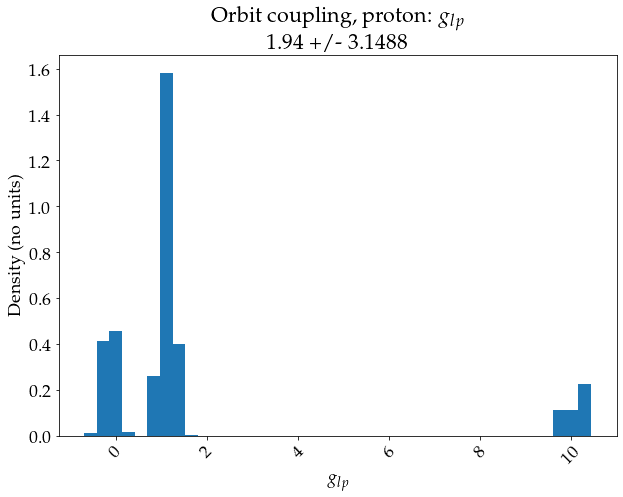

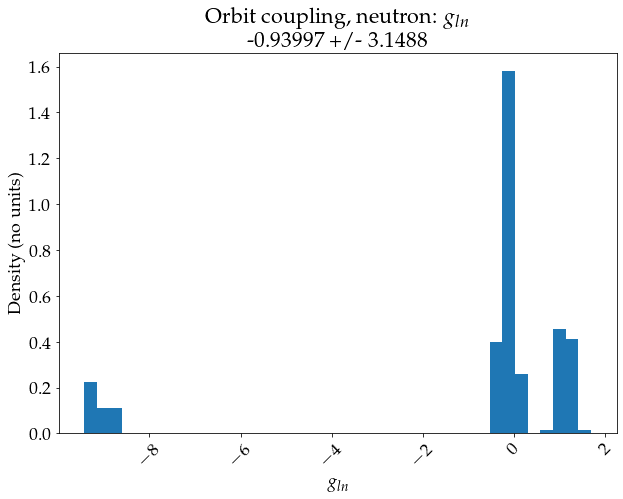

In [8]:
g_sp_free = 5.5857
g_sn_free = - 3.8263
g_lp_free = 1.0
g_ln_free = 0.0
g_lis_free = g_lp_free + g_ln_free

g_sp_trace = 0.5*(g_sis_trace + g_siv_trace)
g_sn_trace = 0.5*(g_sis_trace - g_siv_trace)
g_lp_trace = 0.5*(g_lis_free + g_liv_trace)
g_ln_trace = 0.5*(g_lis_free - g_liv_trace)

make_hist(g_sp_trace,r'Spin coupling, proton: $g_{sp}$',r'$g_{sp}$')
make_hist(g_sn_trace,r'Spin coupling, neutron: $g_{sn}$',r'$g_{sn}$')
make_hist(g_lp_trace,r'Orbit coupling, proton: $g_{lp}$',r'$g_{lp}$')
make_hist(g_ln_trace,r'Orbit coupling, neutron: $g_{ln}$',r'$g_{ln}$')

## spin part, after cuts

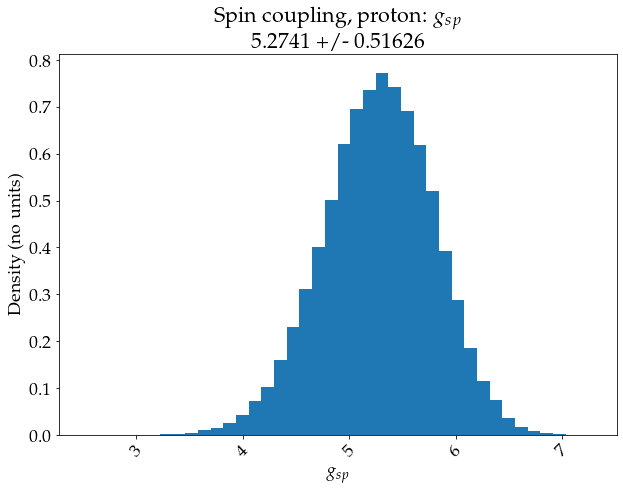

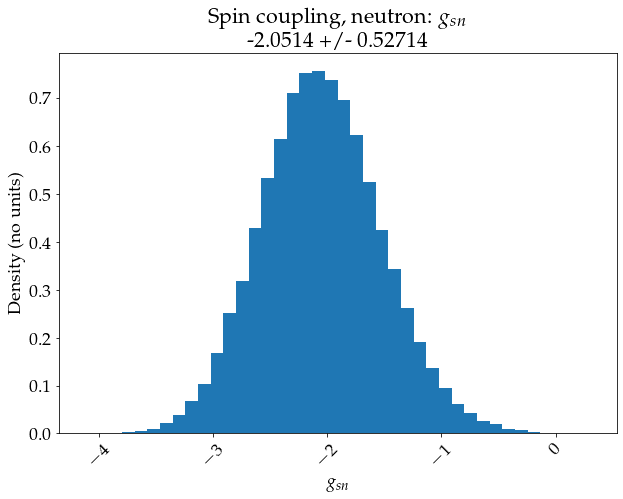

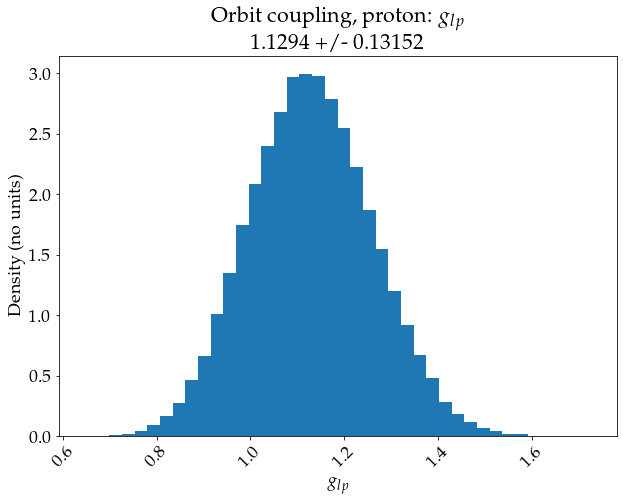

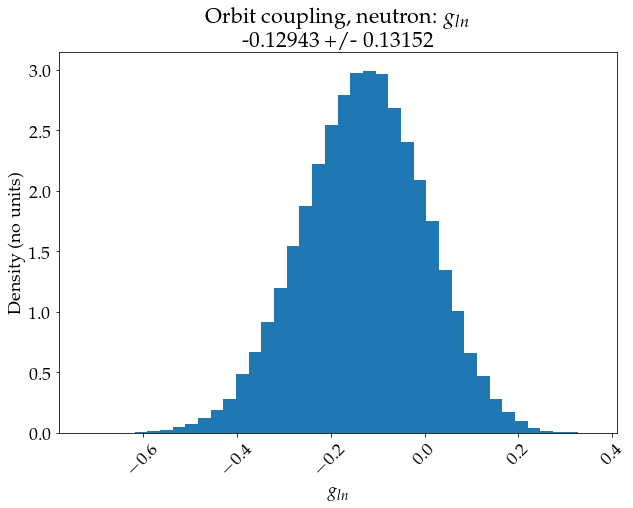

In [9]:
g_sp_low_limit = 2
g_sp_top_limit = 8
g_sn_low_limit = -5
g_sn_top_limit = 0

# indices = (g_sp_trace > g_sp_low_limit) & (g_sp_trace < g_sp_top_limit) & (g_sn_trace > g_sn_low_limit) & (g_sn_trace < g_sn_top_limit)  
indices = (g_sp_trace > g_sp_low_limit) & (g_sp_trace < g_sp_top_limit)  
g_sp_trace = g_sp_trace[indices]
g_sn_trace = g_sn_trace[indices]
g_lp_trace = g_lp_trace[indices]
g_ln_trace = g_ln_trace[indices]

make_hist(g_sp_trace,r'Spin coupling, proton: $g_{sp}$',r'$g_{sp}$')
make_hist(g_sn_trace,r'Spin coupling, neutron: $g_{sn}$',r'$g_{sn}$')
make_hist(g_lp_trace,r'Orbit coupling, proton: $g_{lp}$',r'$g_{lp}$')
make_hist(g_ln_trace,r'Orbit coupling, neutron: $g_{ln}$',r'$g_{ln}$')

cc = [[ 1.          0.11128562 -0.6885903   0.6885903 ]
 [ 0.11128562  1.          0.36617779 -0.36617779]
 [-0.6885903   0.36617779  1.         -1.        ]
 [ 0.6885903  -0.36617779 -1.          1.        ]]


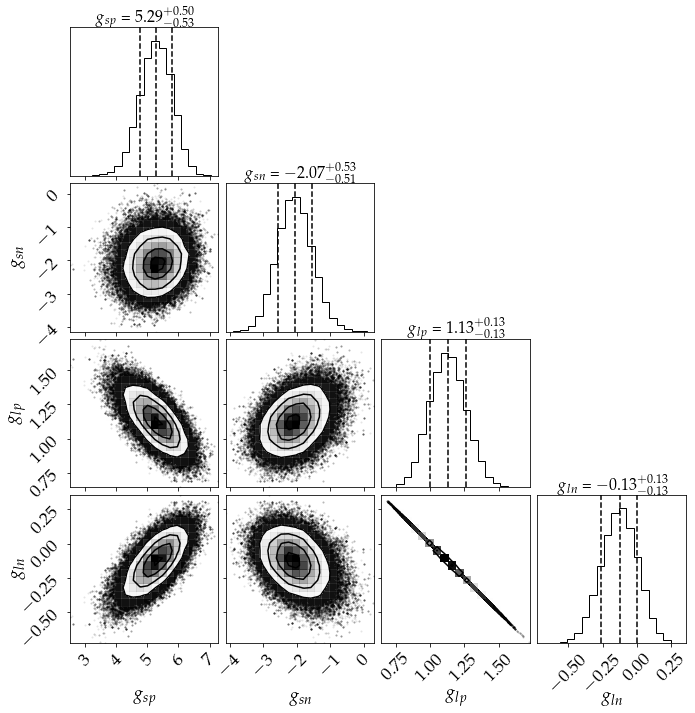

In [13]:
import corner

data = np.array([g_sp_trace.flatten(),g_sn_trace.flatten(),g_lp_trace.flatten(),g_ln_trace.flatten()]).T

f = plt.figure(figsize=(10,10))
figure = corner.corner(data,
                       labels=[r'$g_{sp}$',r'$g_{sn}$',r'$g_{lp}$',r'$g_{ln}$'],
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 16},
                      fig=f)

print(f'cc = {np.corrcoef(data.T)}')